In [ ]:
#Treinar com passado e testar com futuro...
#Growing windows
#Sliding Window
#Treino 1 semana e testo 1 mes
# Treino 2 semanas e testo 1 mes
# Começar com um lastro de dados...
# Media do modelo a evoluir ao longo do mes
# Random forest, support vector, 

# Fazer em R!

In [108]:
import utente
import pandas as pd
import numpy as np
import math

import pandas_profiling as pf
pd.options.display.max_columns = 100
pd.options.display.max_rows = 600

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Carregamento estrutura dados (passar parâmetro forceFetch = True para forçar leitura BD >> Demorado!)
listaUtentes = utente.ListaUtentes(forceFetch = False, sqlLimit = 99999999999) # Carrega dados locais a partir de PICKLE

Loading from ./temp/ListaUtentes.pickle
Finished


In [75]:
# Criação do dataframe pandas
df = pd.DataFrame(listaUtentes.generateDataset())
#listaUtentes = None # Limpa listaUtentes depois de gerar Dataset

## Limpeza das variáveis

Substituição de `None` por 0's e correcção do Types

In [76]:
# Substitui por 0 todos Nones nas colunas que 
# começam por NrAnulacoesPorMotivo ou NrApresentacoesComResultado
filter_col = [col for col in df if col.startswith('NrAnulacoesPorMotivo') 
                                   or col.startswith('NrApresentacoesComResultado')]

for col in filter_col:
    df[col].fillna(value=0, inplace = True);
    df[col]=df[col].astype('int');
    
df['CursoAnoConclusao'].fillna(value=np.nan, inplace = True)
df['NrDescendentesCargo'].fillna(value=np.nan, inplace = True)
df['NrDescendentesCargo'].fillna(value=0, inplace = True)

df['Empregado'] = df['Empregado'].astype('category')
df['Idade'] = df['Idade'].astype('int')
df['NrDescendentesCargo'] = df["NrDescendentesCargo"].str.replace(",", ".").fillna(0)
df['NrDescendentesCargo'] = df["NrDescendentesCargo"].fillna(0).astype('float').astype('int')

df['NrPessoasCargo'] = df["NrPessoasCargo"].fillna(0).astype('float').astype('int')

## Preparação dos dados

In [77]:
# Filtrar observacoes das quais se tem informação do período exacto de desemprego
dfM = df[df.Empregado =='S']

# Filtrar observacoes para periodo 2007 -> 2007
dfM = dfM[(dfM.Data.dt.year > 2006) & (dfM.Data.dt.year < 2018)]

colNamesToDummify = ['Sexo', 
                     'RSI', 
                     'CategoriaAtrib', 
                     'Empregado', 
                     'EstadoCivil', 
                     'FormacaoProf', 
                     'HabilitacaoEscolar',
                     'Nacionalidade',
                     'Qualificacao']
for colName in colNamesToDummify:
    df_dummies = pd.get_dummies(dfM[colName], prefix=colName+'')
    dfM = pd.concat([dfM, df_dummies], axis = 1)
    dfM.drop(colName, axis = 1)
    
colNamesToDrop = ['AreaCurso', 
                  'AreaFormacao', 
                  'CnpAnterior', 
                  'ConjugeMotivoIndisponibilidade',
                  'CursoEstabelecimentoEnsinoSup',
                  #'Data',
                  'DataNascimento',
                  'LTU',
                  'Utente',
                  'CursoAnoConclusao']

dfM.drop(colNamesToDummify, axis = 1, inplace = True)
dfM.drop(colNamesToDrop, axis = 1, inplace = True)

In [90]:
dfM.dtypes
dfM.shape

DiasDesemprego                                                                                                        int64
Idade                                                                                                                 int32
NivelDeficiencia                                                                                                      int64
NrAnulacoes                                                                                                           int64
NrAnulacoesPorMotivo_CADUCIDADE DO DOCUMENTO DE IDENTIFICAÇÃO                                                         int32
NrAnulacoesPorMotivo_COLOCAÇÃO - CANDIDATURA EXTERNA                                                                  int32
NrAnulacoesPorMotivo_COLOCAÇÃO POR MEIOS PRÓPRIOS, POR CONTA DE OUTREM                                                int32
NrAnulacoesPorMotivo_COLOCAÇÃO POR MEIOS PRÓPRIOS, POR CONTA PRÓPRIA                                                  int32
NrAnulac

## Functions

In [131]:
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
import seaborn as sns
import matplotlib.pyplot as plt
import sys

### Growing Window Validation

def growinWinValidation(model, df, dias_lastro = 365, dias_train_inc = 7, dias_test_inc = 30):
    
    
    total_days = (df.Data.max()-df.Data.min()).days
    lastro_dataI = df.Data.min()
    lastro_dataF = lastro_dataI + timedelta(days=dias_lastro)

    train_dataI = lastro_dataF

    i=0 
    metricsTS = []
    test_dataI = df.Data.min() # inicializar
    
    while test_dataI < df.Data.max():  # Enquanto tivermos observacoes para testar no testset
        i+=1
        train_dataF = train_dataI + timedelta(days = dias_train_inc*i)

        test_dataI = train_dataF
        test_dataF = test_dataI + timedelta(days = dias_test_inc)

        train=df[(df.Data > train_dataI) & (df.Data < train_dataF)]
        test=df[(df.Data >= test_dataI) & (df.Data < test_dataF)]

        #print("TrainSize:{} TestSize{}".format(len(train), len(test)))

        #Split data in train set and test set

        y_train = train['DiasDesemprego']
        X_train = train.drop(['DiasDesemprego', 'Data'], axis = 1)

        y_test = test['DiasDesemprego']
        X_test = test.drop(['DiasDesemprego', 'Data'], axis = 1)    

        y_pred_model = model.fit(X_train, y_train).predict(X_test)

        metricsTS.append({'DataF_Test':test_dataF,
                                'R2Score': r2_score(y_test, y_pred_model),
                                'MAError': mean_absolute_error(y_test, y_pred_model),
                                'EVScore': explained_variance_score(y_test, y_pred_model)})
        
        elapsed_days = (test_dataF-df.Data.min()).days
        sys.stdout.write("\r" + str("Completed: {}%".format(int(elapsed_days/total_days*100))))
        sys.stdout.flush()
        
    print("Finish!!")    
    df_metricsTS = pd.DataFrame(metricsTS)
    
    return df_metricsTS
    ##sns.lmplot(x="DataF_Test", y="R2", data=df_metricsTS)

#dfM.Data + timedelta(days=2)

## Feature Selection

In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

XBestFeat = SelectKBest(chi2, k=30).fit_transform(X, y)

Data                                                                                                                  datetime64[ns]
DiasDesemprego                                                                                                                 int64
Idade                                                                                                                          int64
NivelDeficiencia                                                                                                               int64
NrAnulacoes                                                                                                                    int64
NrAnulacoesPorMotivo_CADUCIDADE DO DOCUMENTO DE IDENTIFICAÇÃO                                                                  int64
NrAnulacoesPorMotivo_COLOCAÇÃO - CANDIDATURA EXTERNA                                                                           int64
NrAnulacoesPorMotivo_COLOCAÇÃO POR MEIOS PRÓPRIOS, POR CONTA DE OUTRE

## Modelling

### LASSO Model

In [132]:
from sklearn.linear_model import Lasso

alpha = 0.01
lasso = Lasso(alpha=alpha, max_iter=1000, normalize = False, warm_start = False, tol = 0.1)

#y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)

print(lasso)
metricas = growinWinValidation(lasso, dfM, dias_lastro = 365, dias_train_inc = 21, dias_test_inc = 30)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.1, warm_start=False)
Completed: 100%Finish!!


In [123]:
metrics

,DataF_Test,MAE,R2
0,2008-02-22,325.874481,-6.190793
1,2008-03-14,208.741309,-2.778351
2,2008-04-04,195.182997,-0.299785
3,2008-04-25,184.764146,-0.267526
4,2008-05-16,201.975124,-0.205996
5,2008-06-06,197.730736,-0.048314
6,2008-06-27,179.433873,-0.225629
7,2008-07-18,172.992659,-0.214137
8,2008-08-08,161.082437,-0.089844
9,2008-08-29,178.215797,-0.180620


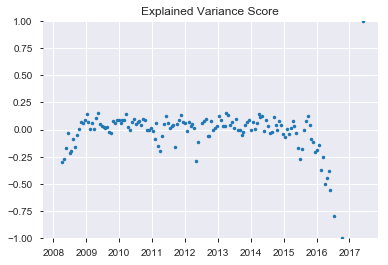

In [140]:
plt.plot(metricas.DataF_Test, metricas.EVScore, '.')
plt.title('Explained Variance Score');
plt.ylim(-1,1);

#plt.yscale('log')

In [73]:
(y_pred_lasso-y_test)/y_test*100

103149   -4.956605e+01
2257     -1.100818e+01
18030     1.739139e+02
63992     7.301911e+00
16347     2.190087e+03
85503     1.797914e+02
21941     9.925482e+02
36672    -4.576454e+01
16413     1.890371e+01
43735     3.562750e+02
14260     1.546722e+03
105086    8.395907e+02
14123    -2.043946e+00
76119    -7.468630e+01
13962     1.836084e+02
32631    -5.059655e+01
84479    -8.984256e+01
5620     -6.149947e+01
105200   -6.821347e+00
29585    -2.027090e+01
113539   -7.915228e+01
40221     3.040543e+01
58607    -5.413845e+01
2508      3.443177e+00
110364    6.791567e+01
117110    6.553652e+01
51962    -6.539319e+01
102092    1.198293e+02
118828    2.352196e+03
51781     6.545267e+02
77950     1.294484e+02
97567     5.005719e+02
29086    -1.686514e+01
113220    1.867691e+02
11889    -2.482048e+01
85871     7.872486e+01
4632      2.493476e+02
87387    -1.422965e+01
101770   -4.817608e+01
39210     2.249993e+02
121919    5.255373e+02
103996    8.301460e+01
48098     7.356128e+03
7968      2

### ElasticNet Model

In [34]:
from sklearn.linear_model import ElasticNet

alpha = 0.01
enet = ElasticNet(alpha=alpha, l1_ratio=0.0)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)

print(enet)
print("r^2 on test data : %f" % r2_score(y_test, y_pred_enet))
print("Mean Abs Error on test data : %f" % mean_absolute_error(y_test, y_pred_enet))

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.063938
Mean Abs Error on test data : 180.117865


c:\users\helio.teixeira\onedrive\python\iefp_dssg\venv64\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### SVM Model

In [11]:
import numpy as np
from sklearn.svm import SVR

#svr_lin = SVR(kernel='linear', C=1e3)
svr_lin = SVR(C=1e3)



y_pre_svmlin = svr_lin.fit(X_train, y_train).predict(X_test)

print(svr_lin)
print("r^2 on test data : %f" % r2_score(y_test, y_pre_svmlin))
print("Mean Abs Error on test data : %f" % mean_absolute_error(y_test, y_pre_svmlin))

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
r^2 on test data : -0.035265
Mean Abs Error on test data : 162.927234


### SGD Regressor

In [12]:
import numpy as np
from sklearn import linear_model

sgd_regr = linear_model.SGDRegressor()


y_pre_sgdreg = sgd_regr.fit(X_train, y_train).predict(X_test)

print(sgd_regr)
print("r^2 on test data : %f" % r2_score(y_test, y_pre_sgdreg))
print("Mean Abs Error on test data : %f" % mean_absolute_error(y_test, y_pre_sgdreg))


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
r^2 on test data : -586489127290375424.000000
Mean Abs Error on test data : 95542609636.052505


/Users/helioteixeira/Documents/Code/Python/IEFP_DSSG/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


### Ridge Regression

In [22]:
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt

reg = linear_model.Ridge (alpha = .5)

# #############################################################################
# Compute paths

n_alphas = 10
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False);
    ridge.fit(X, y);
    coefs.append(ridge.coef_);

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs);
ax.set_xscale('log');
ax.set_xlim(ax.get_xlim()[::-1]);  # reverse axis
plt.xlabel('alpha');
plt.ylabel('weights');
plt.title('Ridge coefficients as a function of the regularization');
plt.axis('tight');
plt.show()


#print(enet)
#print("r^2 on test data : %f" % r2_score(y_test, y_pred_enet))
#print("Mean Abs Error on test data : %f" % mean_absolute_error(y_test, y_pred_enet))


/Users/helioteixeira/Documents/Code/Python/IEFP_DSSG/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.739376102529297e-19 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/helioteixeira/Documents/Code/Python/IEFP_DSSG/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.147019562156858e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/helioteixeira/Documents/Code/Python/IEFP_DSSG/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.315924732761989e-17 / 1.1102230246251565e-16
  RuntimeWarning)


In [26]:
X_train.dtypes

Idade                                                                                                                 int32
NivelDeficiencia                                                                                                      int64
NrAnulacoes                                                                                                           int64
NrAnulacoesPorMotivo_CADUCIDADE DO DOCUMENTO DE IDENTIFICAÇÃO                                                         int32
NrAnulacoesPorMotivo_COLOCAÇÃO - CANDIDATURA EXTERNA                                                                  int32
NrAnulacoesPorMotivo_COLOCAÇÃO POR MEIOS PRÓPRIOS, POR CONTA DE OUTREM                                                int32
NrAnulacoesPorMotivo_COLOCAÇÃO POR MEIOS PRÓPRIOS, POR CONTA PRÓPRIA                                                  int32
NrAnulacoesPorMotivo_CORRECÇÃO COLOCAÇÃO FME                                                                          int32
NrAnulac

***

In [7]:
pf.ProfileReport(df)

Number of variables,111
Number of observations,123701
Total Missing (%),5.5%
Total size in memory,103.9 MiB
Average record size in memory,881.0 B
Numeric,51
Categorical,17
Date,1
Text (Unique),0
Rejected,42
Distinct count,1529


## Notas soltas

**Window Validation**

"Your understanding about sliding window analysis is generally correct. You may find it helpful to separate the model validation process from the actual forecasting. In model validation, you use kinstances to train a model that predicts "one step" forward. Make sure each of your k instances uses only information available at that particular time. This can be subtle, because it is easy to accidentally peek ahead into the future and pollute your out-of-sample test.

For example, you might accidentally use the entire time series history in feature selection, and then use those features to test the model at every step of time. This is cheating, and will give you an overestimate of accuracy. This is mentioned in Elements of Statistical Learning, but outside the sliding window time series context.

It is also easy to accidentally pollute with future information if some of your independent variables are asset returns. Say I use the return on an asset from time t=21"

http://www.simafore.com/blog/bid/110752/Time-Series-Forecasting-from-windowing-to-predicting-in-RapidMiner